In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances 

In [2]:
follow_df = pd.read_csv("follows.csv", header=0, names=['follower_id', 'followee_id'], dtype=np.int32)

interest_df = pd.read_csv("interests.csv", header=0, names=['user_id', 'category'], 
                          dtype={'user_id':np.int32, 'category':np.str})

In [3]:
def strip(word):
    return word.strip()

# stripping spaces from strings in interest_df
interest_df['category'] = interest_df['category'].apply(strip)


In [4]:
follower_id = follow_df['follower_id']
followee_id = follow_df['followee_id']
interests_id = interest_df['user_id']

follower_s = set(follower_id)
followee_s = set(followee_id)
interests_id_s = set(interests_id)

# set of all user ids with no duplicates 
ids_s = follower_s | followee_s | interests_id_s


In [5]:
# Building the ratings matrix 
n_users = len(ids_s) 
largest_id = max(ids_s)
n_interests = interest_df['category'].nunique()

In [6]:
# users relationship matrix
user_mat = np.zeros((largest_id + 1, largest_id + 1))

# ratings[i,j] = 1 if user i follows user j
user_mat[follower_id, followee_id] = 1

indices = np.array(list(ids_s))

# only keeping the relevant rows and columns
user_mat = user_mat[indices, :]
user_mat = user_mat[:, indices]

# defining a dataframe for ratings 
users_df = pd.DataFrame(data=user_mat, index=indices, columns=indices, dtype=np.int32)

In [8]:
# users interest category matrix
interest_df_grp = interest_df.groupby('user_id')['category'].apply(list)
interests_list = list(set(interest_df['category']))

cat_df = pd.DataFrame(np.zeros((n_users, n_interests)), index=users_df.index, 
                      columns=interests_list)

for index in interest_df_grp.index:
    for interest_cat in interest_df_grp[index]:
        cat_df.loc[index, interest_cat] = 1

cat_df = cat_df.astype(int)

In [9]:
ratings_df = pd.concat([users_df, cat_df], axis=1)

In [ ]:
def similarity(df):
    """Returns the similarities"""
    
    # calculate jaccard distances between users
    dist = pairwise_distances(df, metric='jaccard')
    
    # set division by zero nan values to the maximum value i.e 1
    dist[np.isnan(dist)] = 1
    
    #calculate similarities
    sim = 1 - dist
    sim = sim/sim.sum(axis=1)[:, None]
    
    # create the similarity dataframe
    p = pd.DataFrame(sim, index=df.index, columns=df.index)
    
    return p

#similarity based on following other users
jaccard1 = similarity(users_df)
#similarity based on being followed
jaccard2 = similarity(users_df.T)
#similarity based on interests
jaccard3 = similarity(cat_df)

In [11]:
#creating the user combinations based on target 1's 
users_df[users_df == 1]
users_1_List = users_df.where(users_df == 1).stack().index.values.tolist()

#removing duplicates
sorted_tuples = [ tuple(sorted(t)) for t in users_1_List ]
users_1_List = list(set(sorted_tuples))
print("number of unique combinations for target 1's are: " , len(users_1_List))

number of unique combinations for target 1's are:  37809


In [15]:
#creating the user combinations based on target 0's 
users_df2 = users_df.T
u = users_df2+users_df
users_0_List = u.where(u == 0).stack().index.values.tolist()

#deducting diagonals
non_diagonals = [(lambda x,y: x == y)(x,y) for (x,y) in users_0_List]
users_0_List = [users_0_List[i] for i in range(len(users_0_List)) if non_diagonals[i] == False]

#removing duplicates
sorted_tuples = [ tuple(sorted(t)) for t in users_0_List]
users_0_List = list(set(sorted_tuples))
print("number of unique combinations for target 0's are: " , len(users_0_List))

number of unique combinations for target 0's are:  6436793


In [16]:
#randomly selecting the target 0's
import random
index = random.sample(range(len(users_0_List)), len(users_1_List))
users_0_List = [users_0_List[i] for i in index]
users_list = users_1_List + users_0_List

In [17]:
target_0 = [0]*(len(users_1_List))
target_1 = [1]*(len(users_1_List))
target_list = target_1 + target_0

In [18]:
jaccard1_list = []
jaccard2_list = []
jaccard3_list = []

for (x,y) in users_list:
    jaccard1_list.append(jaccard1.loc[x,y])
    jaccard2_list.append(jaccard2.loc[x,y])
    jaccard3_list.append(jaccard3.loc[x,y])

In [19]:
#checking before creating the training set dataframe
print(len(jaccard1_list))
print(len(jaccard2_list))
print(len(jaccard3_list))
print(len(target_list))
print(len(users_list))


75618
75618
75618
75618
75618


In [21]:
#building the dataframe for training data and labels
training_pd = pd.DataFrame({'Jaccard1': jaccard1_list,
                            'Jaccard2': jaccard2_list,
                            'Jaccard3': jaccard3_list,
                             'targets': target_list}, index=users_list)
training_pd.head()

,Jaccard1,Jaccard2,Jaccard3,targets
"(196, 6216)",0.000021,0.000137,0.000132,1
"(1488, 1924)",0.000140,0.000309,0.000382,1
"(1358, 2418)",0.000016,0.000021,0.000202,1
"(36, 4912)",0.000159,0.000184,0.000000,1
"(2746, 3042)",0.000525,0.000376,0.000423,1


C:\Users\Samini\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Samini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


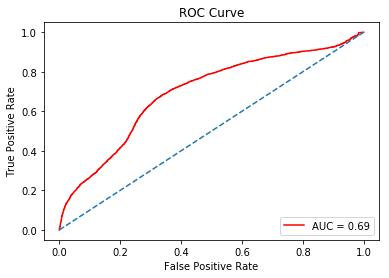

In [23]:
# Training and Testing the Classification Model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.externals import joblib

#Segregating into feature and target set
feature = training_pd.iloc[:,:3]
target = training_pd.iloc[:,3:]


# Splitting the data into training and test data
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=0)

# We shall run the Logistic Regression Model as the targets are binary
logReg = LogisticRegression()

logReg.fit(x_train, y_train)
#saving the model
joblib.dump(logReg, 'logistic.joblib')

# Ruuning the model on the data and computing the probabilities
y_prob = logReg.predict_proba(x_test)[:,1]

# Plotting the ROC Curve
FPR, TPR, Thresh = roc_curve(y_test, y_prob)
roc_auc = auc(FPR, TPR)
plt.plot(FPR,TPR, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [24]:
def create_similarity(index1, not_followed):
    """
    Given the user index1 and the list "not_followed" of users not being followed by index1,
    this computes the corresponding jaccards and returns the created dataframe
    """
    jacc1 = []
    jacc2 = []
    jacc3 = []
    user2 = []
    user1 = []
    
    for index2 in not_followed:
        if index1 != index2:
            user1.append(index1)
            user2.append(index2)
            jacc1.append(jaccard1.loc[index1,index2])
            jacc2.append(jaccard2.loc[index1,index2])
            jacc3.append(jaccard3.loc[index1,index2])

    test_pd = pd.DataFrame({'User1': user1,
                            'User2':user2,
                            'Jaccard1': jacc1,
                            'Jaccard2': jacc2,
                            'Jaccard3': jacc3})
    return test_pd  

In [25]:
def recommend_followee(users_df, k, ind):
    """
    Given user matrix user_df, returns top k recommendation ids for the user index 'ind' 
    Returns a list of user id-s that are recommended for the user
    """
    
    # List of users that are not being followed by user 'ind'. We only run the model on these users
    not_followed = users_df.columns.values[users_df.loc[ind]==0]

    # Call function to create the jaccrd similariy features for user 'ind'
    # and all its non-followees
    reco_df = create_similarity(ind, not_followed)
    
    # Running the model on the new dataframe
    #Loading the model
    logReg = joblib.load('logistic.joblib')

    # Extracts the features to be fed into the model from the dataframe and feeds it into the model
    data = reco_df.iloc[:, 2:]
    y_prob = logReg.predict_proba(data)[:,1]
    reco_df['Probability'] = y_prob
    
    #Computes the k largest probabilities
    k_largest = reco_df.nlargest(k, 'Probability')
    
    return(list(k_largest['User2']))   

In [26]:
def make_test(users_df, n):
    """
    Creates a mock test dataset by randomly masking n followees for users who follow more than 20 other users
    This dataset will be used to test how many of these user ids the recommendation system will capture
    """
    
    # selecting user who have at least 20 followees
    test_users_df = users_df[users_df.sum(axis=1)>20]
    test_users_df = test_users_df.astype(int)
    
    # dictionary to store the followees for these users
    test_users_dict = {}
    
    # dictionary to store the masked followee ids
    test_zero_dict = {}
    
    for user in test_users_df.index:
        # values for test_users dictionary: their complete list of followees
        test_users_dict[user] = (test_users_df.columns.values[test_users_df.loc[user]==1])
        
        # values for test_zero_users dictionary: list of masked followees
        test_zero_dict[user] = random.sample(list(test_users_dict[user]), n)
        
    # setting zeros in the user matrix for the random list generated before 
    test_df = users_df.copy()
    for user in test_zero_dict:
        test_df.loc[user, test_zero_dict[user]] = 0
        
    return(test_zero_dict, test_df)

In [27]:
# defining functions to calculate precision and recalls for two input sets
def prec(predicted, correct):
    """Computes precision"""
    
    p = set(predicted)
    c = set(correct)
    return len(p & c)/len(p)

def rec(predicted, correct):
    """Computes recall"""
    
    p = set(predicted)
    c = set(correct)
    return len(p & c)/len(c)

In [28]:
def prec_recomm(test_users_df, test_zero_dict, k):
    """ Calculates precision of the recommendation system  
        recommends top k users
    """
    
    prec_eval = []

    for user in test_zero_dict:   
        # keeping record of actual followees of the user which we have masked for testing
        actual_follow = test_zero_dict[user]
        
        recom_follow = recommend_followee(test_users_df, k, user)        
        prec_eval.append(prec(recom_follow, actual_follow))
        
    return prec_eval

In [29]:
def recall_recomm(test_users_df, test_zero_dict, k):
    """ Calculates recall of the recommendation system  
        recommends top k users
    """
    
    recall_eval = []

    for user in test_zero_dict:      
        # keeping record of actual followees of the user which we have masked for testing
        actual_follow = test_zero_dict[user]
        
        recom_follow = recommend_followee(test_users_df, k, user)        
        recall_eval.append(rec(recom_follow, actual_follow))
        
    return recall_eval

In [30]:
# Make a test set. 10 is the numbers of masked followees
test_zero_dict, test_users_df = make_test(users_df, 10)

In [31]:
for k in [1,5,10,20]:   
    p_list = prec_recomm(test_users_df, test_zero_dict, k)
    print("average precision @ {}: {:1.2f}".format(k, np.mean(p_list)))

average precision @ 1: 0.28
average precision @ 5: 0.18
average precision @ 10: 0.14
average precision @ 20: 0.10


In [33]:
for k in [1,5,10,20]:    
    r_list = recall_recomm(test_users_df, test_zero_dict, k)
    print("average recall @ {}: {:1.2f}".format(k, np.mean(r_list)))

average recall @ 1: 0.03
average recall @ 5: 0.09
average recall @ 10: 0.14
average recall @ 20: 0.19
